In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

device = torch.device('cuda') 

## Background
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

[Link to the ResNet paper](https://arxiv.org/abs/1512.03385)

In [55]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1): # dilation=1 is the default value in Pytorch (standard conv)
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual # adding the original input (additive skip connection)
        out = self.relu(out)
        return out


# Classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('res_block', ResidualBlock(in_channels=3, out_channels=3))
        self.net.add_module('mp1', nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1))
        self.net.add_module('dp1', nn.Dropout2d(p=0.25))
        self.net.add_module('fl1', nn.Flatten())
        self.net.add_module('fc1', nn.Linear(in_features=768, out_features=128))
        self.net.add_module('rl3', nn.ReLU())
        self.net.add_module('dp2', nn.Dropout(p=0.5))
        self.net.add_module('fc2', nn.Linear(in_features=128, out_features=10))
        self.net.add_module('sm1', nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.net(x)


def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights)

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

lossfun = nn.NLLLoss() 

#CIFAR10

In [56]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, **kwargs)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, **kwargs)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train(model, train_loader, epochs):
    model.train()

    # Define train epochs

    epoch_loss = []
    epoch_accu = []
    for epoch in range(epochs):

        # iterate through train dataset

        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            # get output
            output = model(data)

            # compute loss function
            loss = lossfun(output, target)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # run optimizer 
            optimizer.step()

            # bookkeeping
            accuracy = (output.argmax(-1) == target).float().mean()
            epoch_loss.append(loss.item())
            epoch_accu.append(accuracy.item())

            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy.item()))

        print('Train Epoch: {}\tAverage Loss: {:.6f}\tAverage Accuracy: {:.2f}'.format(
            epoch+1, sum(epoch_loss)/len(epoch_loss), sum(epoch_accu)/len(epoch_accu)))
            
    # save network
    torch.save(model.state_dict(), "cifar10_cnn.pt")
    
    return epoch_loss, epoch_accu

epoch_loss, epoch_accu = train(model, train_loader, epochs=10)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.375725	Accuracy: 0.09
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.993182	Accuracy: 0.29
Train Epoch: 1	Average Loss: 2.008074	Average Accuracy: 0.27
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.850459	Accuracy: 0.31
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.834372	Accuracy: 0.33
Train Epoch: 2	Average Loss: 1.909536	Average Accuracy: 0.31
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.739266	Accuracy: 0.38
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.728239	Accuracy: 0.40
Train Epoch: 3	Average Loss: 1.850550	Average Accuracy: 0.33
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.649170	Accuracy: 0.41
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.613557	Accuracy: 0.40


In [51]:
def test(model, test_loader):
    # put model in the evaluation mode
    model.eval()
    test_loss = 0
    test_accu = 0

    with torch.no_grad(): # no need to compute gradients; also saves time and memory

        # iterate through test set
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data)

            # bookkeeping
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # loss
            test_accu += (output.argmax(dim=-1)==target).float().sum().item()  # accuracy

    test_loss /= len(test_loader.dataset)
    test_accu /= len(test_loader.dataset)

    print('\nTest set: Average Loss: {:.4f}, Accuracy: {:.2f}\n'.format(
        test_loss, test_accu))
    
    return test_loss, test_accu

test_loss, test_accu = test(model, test_loader)


Test set: Average Loss: 1.3228, Accuracy: 0.55



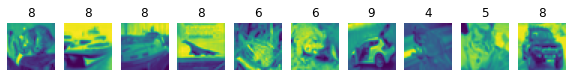

In [52]:
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
        
output = model(data)

plt.figure(figsize=(10,100))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(data[i,0].cpu())
    plt.axis('off')
    plt.title(output[i].argmax().item())
plt.show()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.385275	Accuracy: 0.08
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.917103	Accuracy: 0.34
Train Epoch: 1	Average Loss: 1.999390	Average Accuracy: 0.27
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.896438	Accuracy: 0.31
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.816911	Accuracy: 0.33
Train Epoch: 2	Average Loss: 1.902408	Average Accuracy: 0.31
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.748994	Accuracy: 0.36
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.746033	Accuracy: 0.36
Train Epoch: 3	Average Loss: 1.847719	Average Accuracy: 0.33
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.738480	Accuracy: 0.37
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.679807	Accuracy: 0.38
Train Epoch: 4	Average Loss: 1.809736	Average Accuracy: 0.35
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.641814	Accuracy: 0.41
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.659626	Accuracy: 0.42
Train Epoch: 5	Average Loss: 1.780711	Average Accuracy: 0.36
Train Epoch: 6 [0/50000 (0%)]	Loss: 1.696456	Accuracy: 0.38
Train Epoc

Text(0, 0.5, 'accuracy')

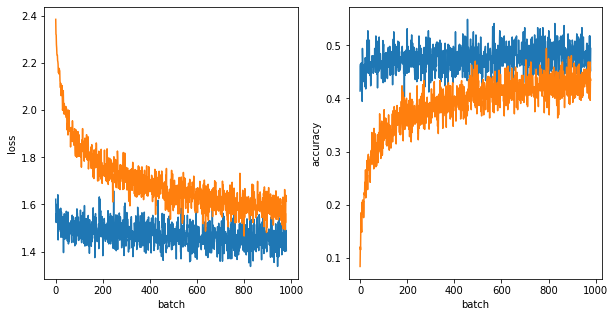

In [53]:
# Remove residual connection

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1): # dilation=1 is the default value in Pytorch (standard conv)
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        #residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        #out += residual # adding the original input (additive skip connection)
        out = self.relu(out)
        return out


# Classifier
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('res_block', ResidualBlock(in_channels=3, out_channels=3))
        self.net.add_module('mp1', nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1))
        self.net.add_module('dp1', nn.Dropout2d(p=0.25))
        self.net.add_module('fl1', nn.Flatten())
        self.net.add_module('fc1', nn.Linear(in_features=768, out_features=128))
        self.net.add_module('rl3', nn.ReLU())
        self.net.add_module('dp2', nn.Dropout(p=0.5))
        self.net.add_module('fc2', nn.Linear(in_features=128, out_features=10))
        self.net.add_module('sm1', nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.net(x)


def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

model.apply(init_weights)

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

lossfun = nn.NLLLoss() 

epoch_loss_bn, epoch_accu_bn = train(model, train_loader, epochs=10)
test_loss_bn, test_accu_bn = test(model, test_loader)

print("Test accuracy with a residual connection: ", test_accu)
print("And without: ", test_accu_bn)

# plot loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epoch_loss); plt.plot(epoch_loss_bn)
plt.xlabel('batch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot(epoch_accu); plt.plot(epoch_accu_bn)
plt.xlabel('batch')
plt.ylabel('accuracy')